In [1]:
%cd /workspace

from pathlib import Path
import seaborn as sns
import re

import numpy as np
import pandas as pd
import polars as pl
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

/workspace


In [2]:
INPUT = Path("/workspace/resources/input")
task_df = pd.read_parquet(INPUT / "task1_dataset.parquet")
task_df.shape

(111535175, 5)

In [3]:
user_ids = task_df["uid"].sample(100, random_state=0)
task_df = task_df[task_df["uid"].isin(user_ids)]
nouse = task_df.query("x == 999")["uid"]
task_df = task_df[~task_df["uid"].isin(nouse)].reset_index(drop=True)

In [4]:
uids = list(set(user_ids) - set(nouse))

In [5]:
train_df = task_df.query("d < 60").reset_index(drop=True)
test_df = task_df.query("d >= 60").reset_index(drop=True)


def assign_day_of_week(df):
    df["dayofweek"] = (df["d"] % 7).astype(int)
    df["weekend"] = df["dayofweek"].isin([6, 0])
    return df


def assign_t_labe(df):
    morning = {k: 0 for k in list(range(12, 36))}
    midnight = {k: 1 for k in list(range(36, 48)) + list(range(0, 12))}
    t_label_mapping = {**morning, **midnight}
    df["t_label"] = df["t"].map(t_label_mapping)
    return df

train_df = assign_day_of_week(train_df)
test_df = assign_day_of_week(test_df)

train_df = assign_t_labe(train_df)
test_df = assign_t_labe(test_df)

In [16]:
keys = ["uid",]
agg_pred_df = (
    train_df.groupby(keys)[["x", "y"]]
    .mean()
    .reset_index()
    .rename(columns={"x": "agg_x", "y": "agg_y"})
)

In [17]:
preds_df = pd.merge(test_df, agg_pred_df, on=keys, how="left")
preds_df["time"] = preds_df["d"].astype(str).str.zfill(2) + preds_df["t"].astype(str).str.zfill(2)
preds_df.isnull().sum().pipe(lambda x: x[x>0])

Series([], dtype: int64)

In [18]:
for col in ['agg_x', 'agg_y']:
    # nan のインデックスを取得
    nan_indices = preds_df[preds_df[col].isna()].index
    for idx in tqdm(nan_indices):
        uid = preds_df.loc[idx, 'uid']
        # その uid の平均値を計算
        mean_value = preds_df[preds_df['uid'] == uid][col].median()
        preds_df.loc[idx, col] = mean_value


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [19]:
mean_squared_error(
    y_true=preds_df[["x", "y"]].values,
    y_pred=preds_df[["agg_x", "agg_y"]],
    squared=False,
)  # 17.91651534400463, (5,6)14.334231519828823, (6,0)14.092105199606246



14.309594200599285

<Axes: xlabel='time', ylabel='agg_x'>

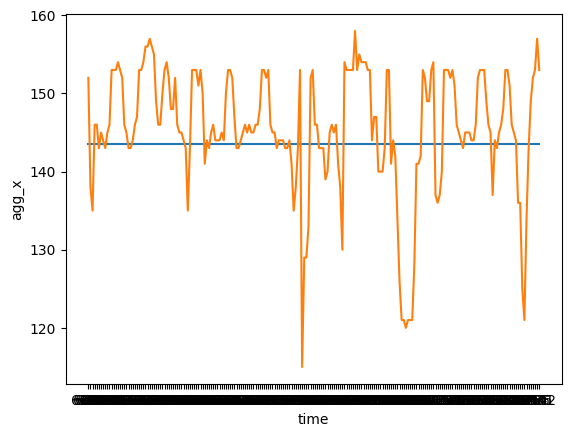

In [20]:
uid = uids[1]

df = preds_df.query("uid == @uid").reset_index(drop=True)
sns.lineplot(data=df, x="time", y="agg_x")
sns.lineplot(data=df, x="time", y="x")

<Axes: xlabel='time', ylabel='agg_y'>

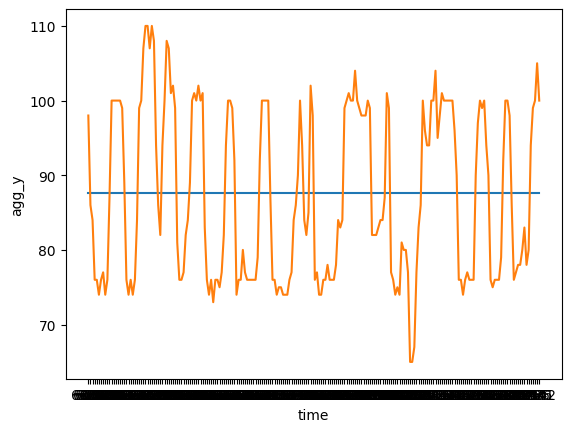

In [21]:
sns.lineplot(data=df, x="time", y="agg_y")
sns.lineplot(data=df, x="time", y="y")

In [22]:
from geobleu import geobleu

n_uid = 0
geobleu_score = 0
dtw_score = 0
rmse = 0

uids = preds_df["uid"].unique()[:10]
sample_df = preds_df[preds_df["uid"].isin(uids)]

for _, df in sample_df.groupby("uid"):
    generated = df[[ "d", "t", "agg_x", "agg_y"]].values.tolist()
    reference = df[[ "d", "t", "x", "y"]].values.tolist()
    geobleu_score += geobleu.calc_geobleu(generated, reference, processes=3)
    dtw_score += geobleu.calc_dtw(generated, reference, processes=3)
    rmse += mean_squared_error(
        y_true=np.array(reference)[:, 2:],
        y_pred=np.array(generated)[:, 2:],
        squared=False,
    )
    n_uid += 1

print(rmse / n_uid)
print(geobleu_score / n_uid)
print(dtw_score / n_uid)

12.445011372072221
0.020383422477972462
68.21785895896149


In [23]:

from geobleu import geobleu

n_uid = 0
geobleu_score = 0
dtw_score = 0
rmse = 0

uids = preds_df["uid"].unique()[:10]
sample_df = preds_df[preds_df["uid"].isin(uids)].reset_index(drop=True)
sample_df["tmp_x"] = sample_df["x"].values + 5
sample_df["tmp_y"] = sample_df["y"].values + 10

for _, df in sample_df.groupby("uid"):
    generated = df[["d", "t", "tmp_x", "tmp_y"]].values.tolist()
    reference = df[[ "d", "t", "x", "y"]].values.tolist()
    geobleu_score += geobleu.calc_geobleu(generated, reference, processes=3)
    dtw_score += geobleu.calc_dtw(generated, reference, processes=3)
    rmse += mean_squared_error(
        y_true=np.array(reference)[:, 2:],
        y_pred=np.array(generated)[:, 2:],
        squared=False,
    )
    n_uid += 1

print(rmse / n_uid)
print(geobleu_score / n_uid)
print(dtw_score / n_uid)

7.5
0.0008285704499749807
86.31694658255387
